In [126]:
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.types import FloatType,StringType,IntegerType
from pyspark.sql.functions import min,udf,to_date,year,to_timestamp,date_format,month
from IPython.display import Image
%matplotlib inline
import pandas
spark = SparkSession.builder.appName('p2').getOrCreate()

### IPO Market 

* Private Company becomes public.
* Public give capital to company and public can invest in same.

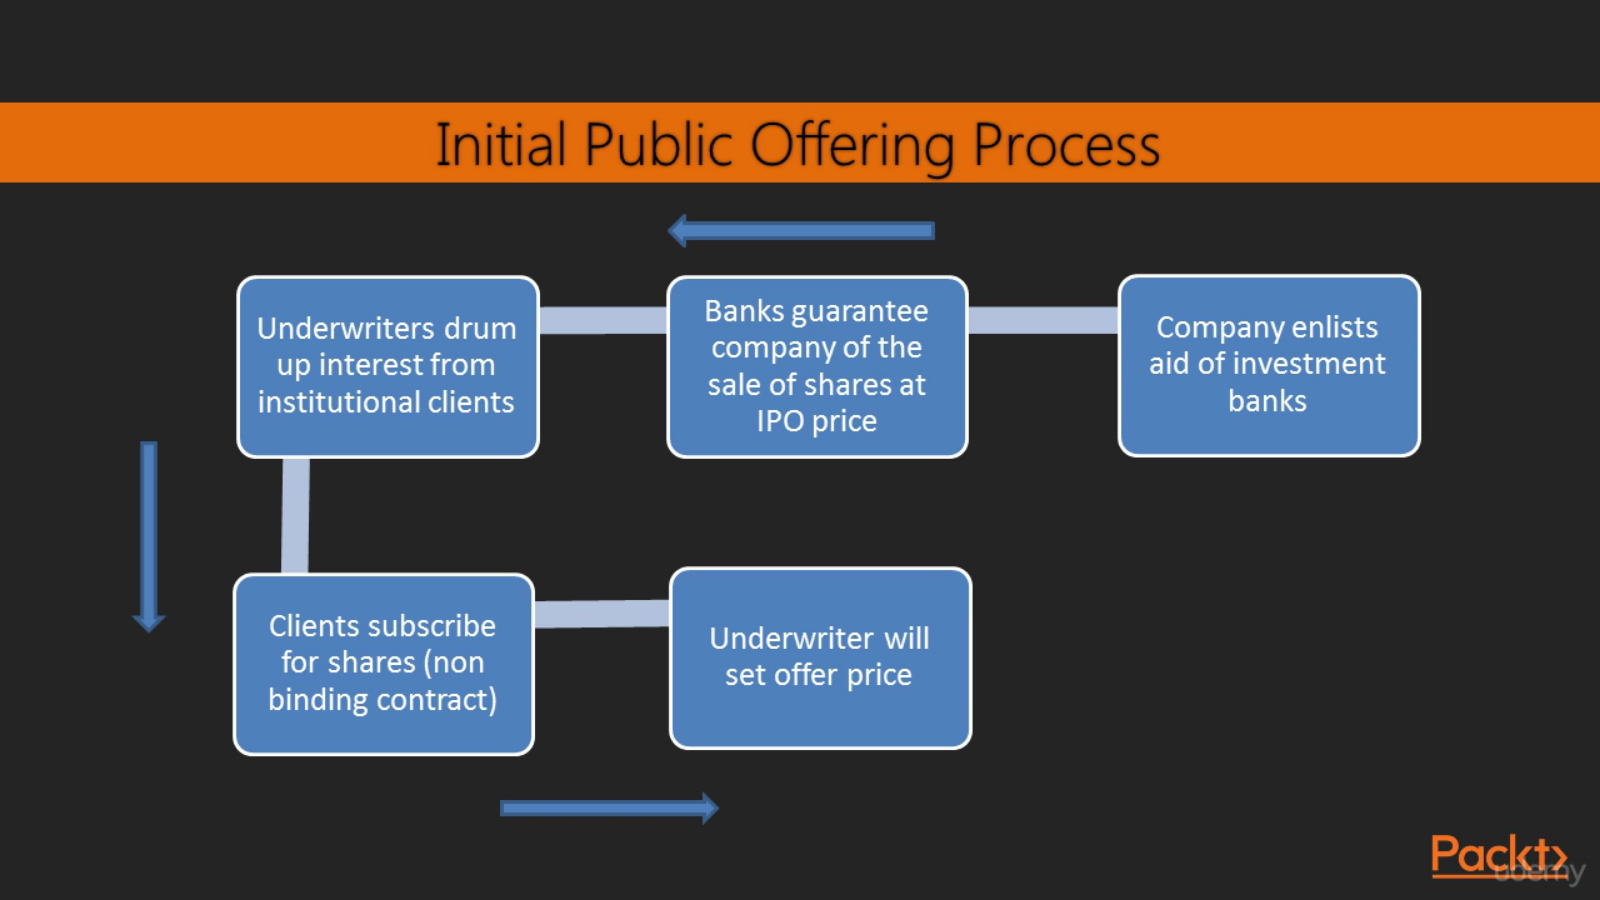

In [91]:
Image(filename='ipo_process.png')

* The underwriter(banks) set the offer price at the day of opening based on interest.
* Usually, Opening price is higher than Offering price.
* Money on Table = Offering price - Closing Price


In [92]:
ipo = spark.read.csv('ipo1.csv', inferSchema=True, header=True)

In [93]:
ipo.printSchema()

root
 |-- Trade Date: string (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- Offer Price: string (nullable = true)
 |-- Opening Price: string (nullable = true)
 |-- 1st Day Close: string (nullable = true)
 |-- 1st Day % Px Chng: string (nullable = true)
 |-- $ Change Opening: string (nullable = true)
 |-- $ Change Close: string (nullable = true)
 |-- Star Ratings: string (nullable = true)
 |-- Performed: string (nullable = true)



Apply the udfs to remove '%' and '$'

In [94]:
def remove_unwanted_chars(x):
    x = str(x)
    if '$' in x:
        return x.replace('$','')
    elif '%' in x:
        return x.replace('%','')
    elif '(' in x:
        return x.replace('(','')
    elif ')' in x:
        return x.replace(')','')
    else:
        return x
def rem_nc(x):
    if 'N/C' in x:
        return x.replace('N/C','')
    else:
        return x

In [95]:
ipo.columns

['Trade Date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'Offer Price',
 'Opening Price',
 '1st Day Close',
 '1st Day % Px Chng',
 '$ Change Opening',
 '$ Change Close',
 'Star Ratings',
 'Performed']

In [96]:
rem_chars = udf(remove_unwanted_chars,returnType=StringType())
rem_nc_val = udf(rem_nc,returnType=StringType())
# rem_per = udf(lambda x:x.replace('%',''), returnType=StringType())
# rem_nc = udf(lambda x:x.replace('N/C','0'), returnType=StringType())

off_price = rem_chars(ipo['Offer Price'])
open_price = rem_chars(ipo['Opening Price'])
price_close = rem_chars(ipo['1st Day Close'])
chg_open = rem_chars(ipo['$ Change Opening'])
chg_close = rem_chars(ipo['$ Change Close'])

per_change = rem_chars(ipo['1st Day % Px Chng'])

nc_change = rem_nc_val(ipo['Star Ratings'])

# ipo.show()


ipo.show()
# ipo.filter(rem_dol(ipo['Offer Price']))

+----------+--------------------+------+-------------------------+-----------+-------------+-------------+-----------------+----------------+--------------+------------+---------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Offer Price|Opening Price|1st Day Close|1st Day % Px Chng|$ Change Opening|$ Change Close|Star Ratings|Performed|
+----------+--------------------+------+-------------------------+-----------+-------------+-------------+-----------------+----------------+--------------+------------+---------+
|   1/20/17|FinTech Acquisiti...| FNTEU|     Cantor Fitzgerald...|     $10.00|       $10.10|       $10.05|            0.50%|           $0.10|         $0.05|           1|     null|
|   1/20/17|        Keane Group |  FRAC|     Citigroup/ Morgan...|     $19.00|       $22.18|       $21.65|           13.95%|           $3.18|         $2.65|           3|     null|
|   1/26/17|         AnaptysBio |  ANAB|     Credit Suisse/ St...|     $15.00|       $16.00|       $

In [97]:
ipo = ipo.withColumn('Offer Price1',off_price.cast('float'))
ipo = ipo.withColumn('Opening Price1',open_price.cast('float'))
ipo = ipo.withColumn('1st Day Close1',price_close.cast('float'))
ipo = ipo.withColumn('$ Change Opening1',chg_open.cast('float'))
ipo = ipo.withColumn('$ Change Close1',chg_close.cast('float'))
ipo = ipo.withColumn('1st Day % Px Chng1',per_change.cast('float'))
ipo = ipo.withColumn('Star Ratings1',nc_change.cast('int'))
x=to_date(ipo['Trade Date'], 'MM/dd/yy').alias('Date')
# x=to_timestamp(ipo['Trade Date'], 'MM/dd/yy').alias('Date')
ipo = ipo.withColumn('Trade Date',x)
ipo.printSchema()
ipo.show()


root
 |-- Trade Date: date (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- Offer Price: string (nullable = true)
 |-- Opening Price: string (nullable = true)
 |-- 1st Day Close: string (nullable = true)
 |-- 1st Day % Px Chng: string (nullable = true)
 |-- $ Change Opening: string (nullable = true)
 |-- $ Change Close: string (nullable = true)
 |-- Star Ratings: string (nullable = true)
 |-- Performed: string (nullable = true)
 |-- Offer Price1: float (nullable = true)
 |-- Opening Price1: float (nullable = true)
 |-- 1st Day Close1: float (nullable = true)
 |-- $ Change Opening1: float (nullable = true)
 |-- $ Change Close1: float (nullable = true)
 |-- 1st Day % Px Chng1: float (nullable = true)
 |-- Star Ratings1: integer (nullable = true)

+----------+--------------------+------+-------------------------+-----------+-------------+-------------+-----------------+--------------

In [98]:
ipo = ipo.drop('Offer Price', 'Opening Price', '1st Day Close', '1st Day % Px Chng', '$ Change Opening', '$ Change Close',
         'Star Ratings')


In [99]:

ipo.printSchema()

root
 |-- Trade Date: date (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- Performed: string (nullable = true)
 |-- Offer Price1: float (nullable = true)
 |-- Opening Price1: float (nullable = true)
 |-- 1st Day Close1: float (nullable = true)
 |-- $ Change Opening1: float (nullable = true)
 |-- $ Change Close1: float (nullable = true)
 |-- 1st Day % Px Chng1: float (nullable = true)
 |-- Star Ratings1: integer (nullable = true)



In [100]:
ipo.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+
|2017-01-20|FinTech Acquisiti...| FNTEU|     Cantor Fitzgerald...|     null|        10.0|          10.1|         10.05|              0.1|           0.05|               0.5|            1|
|2017-01-20|        Keane Group |  FRAC|     Citigroup/ Morgan...|     null|        19.0|         22.18|         21.65|             3.18|           2.65|             13.95|            3|
|2017-01-26|         AnaptysBio |  ANAB|     Credit Suisse/ St...

In [101]:
# ipo2 = ipo.select('Star Ratings1')
ipo.na.fill({'Star Ratings1':0})
ipo = ipo.na.drop(subset='Trade date')

In [102]:
ipo.columns

['Trade Date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'Performed',
 'Offer Price1',
 'Opening Price1',
 '1st Day Close1',
 '$ Change Opening1',
 '$ Change Close1',
 '1st Day % Px Chng1',
 'Star Ratings1']

In [103]:
gpd = ipo.groupby(year(ipo['Trade Date']))
ipo_gpd_mean = gpd.agg({'1st Day % Px Chng1':'mean'}).orderBy('year(Trade Date)')
ipo_gpd_mean.show()

+----------------+-----------------------+
|year(Trade Date)|avg(1st Day % Px Chng1)|
+----------------+-----------------------+
|            2000|     35.562278316430906|
|            2001|      12.76148938213257|
|            2003|     11.944999916478992|
|            2004|     10.703275824929106|
|            2005|      9.910752245546442|
|            2006|      9.988354488044097|
|            2007|      11.52144532170496|
|            2008|      2.318085070937238|
|            2009|      7.175737642240329|
|            2010|      8.654875060752966|
|            2011|      9.044405579306446|
|            2012|     11.961103506643196|
|            2013|      16.35265213996172|
|            2014|     12.363159722402795|
|            2015|     12.610254839727073|
|            2016|     10.979622752809862|
|            2017|      8.165471673363223|
+----------------+-----------------------+



In [104]:

x=to_timestamp(ipo['Trade Date'], 'MM/dd/yy').alias('Trade Date')
ipo1 = ipo.withColumn('Trade Date',x)
pd = ipo1.toPandas()
pd

Trade Date                           Issuer Symbol  \
0    2017-01-20     FinTech Acquisition Corp. II  FNTEU   
1    2017-01-20                     Keane Group    FRAC   
2    2017-01-26                      AnaptysBio    ANAB   
3    2017-01-26                      ObsEva SA     OBSV   
4    2017-01-27              Jagged Peak Energy     JAG   
5    2017-01-27                JELD-WEN Holding    JELD   
6    2017-01-27             Jounce Therapeutics    JNCE   
7    2017-01-27                       REV Group    REVG   
8    2017-02-01                Invitation Homes    INVH   
9    2017-02-01              Laureate Education    LAUR   
10   2017-02-03    Kimbell Royalty Partners, LP     KRP   
11   2017-02-03                Ramaco Resources    METC   
12   2017-02-10                  Clipper Realty    CLPR   
13   2017-02-10   Foundation Building Materials     FBM   
14   2017-02-10                  Sachem Capital    SACH   
15   2017-03-01                   Hamilton Lane    HLNE   
16   2017-03-02                            Snap    SNAP   
17   2017-03-08                          J.JILL    JILL   
18   2017-03-08                    BeyondSpring    BYSI   
19   2017-03-10                        Presidio    PSDO   
20   2017-03-10   Matlin & Partners Acquisition   MPACU   
21   2017-03-15              Ardagh Group S.A.      ARD   
22   2017-03-16           Canada Goose Holdings    GOOS   
23   2017-03-17                        MuleSoft    MULE   
24   2017-03-17                ProPetro Holding    PUMP   
25   2017-03-24                         Alteryx     AYX   
26   2017-03-24  Silver Run Acquisition Corp II   SRUNU   
27   2017-03-30      Kayne Anderson Acquisition   KAACU   
28   2017-04-05       Hess Midstream Partners LP   MESM   
29   2017-04-06              Schneider National    SNDR   
...         ...                              ...    ...   
2775 2000-11-02                 Evergreen Solar    ESLR   
2776 2000-11-02                 Energy Partners     EPL   
2777 2000-11-02                    UTiWorldwide    UTIW   
2778 2000-11-03  Optical Communication Products    OCPI   
2779 2000-11-07                       Transmeta    TMTA   
2780 2000-11-09                         Inficon    IFCN   
2781 2000-11-09                     Go2Pharmacy    GORX   
2782 2000-11-10             Computer Access Tech   CATZ   
2783 2000-11-10                         Aerogen    AEGN   
2784 2000-11-10                        Luminent    LMNE   
2785 2000-11-13                      Syngenta AG    SYT   
2786 2000-11-14            Orion Power Holdings     ORN   
2787 2000-11-14                          Adolor    ADLR   
2788 2000-11-16                Novatel Wireless    NVTL   
2789 2000-11-17                  Array BioPhama    ARRY   
2790 2000-11-17                    Beacon Power    BCON   
2791 2000-11-17                        Dynacare    DNCR   
2792 2000-11-21            Alliance Fiber Optic    AFOP   
2793 2000-11-21                        ImagicTV    IMTV   
2794 2000-11-21              Telekom Austria AG     TKA   
2795 2000-11-22              Telefonica Moviles     TEM   
2796 2000-11-29           Rigel Pharmaceuticals    RIGL   
2797 2000-12-04                      Telenor ASA   TELN   
2798 2000-12-07               Harvard Biosceince   HBIO   
2799 2000-12-08                          Garmin    GRMN   
2800 2000-12-08          Specialty Laboratories      SP   
2801 2000-12-08              W.P. Stewart & Co.     WPL   
2802 2000-12-11                         Gemplus    GEMP   
2803 2000-12-12                           GenVec   GNVC   
2804 2000-12-15            Resources Connection    RECN   

                              Lead/Joint-Lead  Managers Performed  \
0                               Cantor Fitzgerald & Co.      None   
1     Citigroup/ Morgan Stanley/ BofA Merrill Lynch/...      None   
2                                 Credit Suisse/ Stifel      None   
3            Credit Suisse/ Jefferies/ Leerink Partners    Missed   
4

Find the mean of 1st days increase per year in pandas

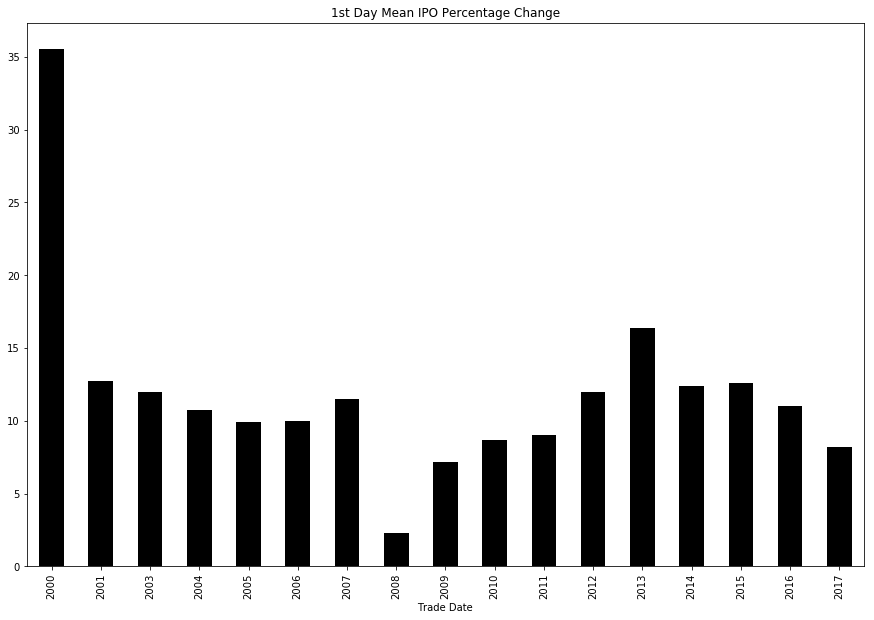

In [105]:
pd.groupby(pd['Trade Date'].dt.year)['1st Day % Px Chng1'].mean().plot(kind='bar', figsize=(15,10), color='k', title='1st Day Mean IPO Percentage Change')


Find the median of 1st days increase per year in pandas

In [106]:
pd.groupby(pd['Trade Date'].dt.year)['1st Day % Px Chng1'].median().plot(kind='bar', figsize=(15,10), color='k', title='1st Day Median IPO Percentage Change')


In [107]:
pd['1st Day % Px Chng1'].describe()

count    2805.000000
mean       13.159790
std        27.705534
min       -35.220001
25%         0.000000
50%         4.500000
75%        19.129999
max       353.850006
Name: 1st Day % Px Chng1, dtype: float64

In [108]:
pd['1st Day % Px Chng1'].hist(figsize=(15,7), bins=100, color='grey')

In [109]:
ipo.columns

['Trade Date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'Performed',
 'Offer Price1',
 'Opening Price1',
 '1st Day Close1',
 '$ Change Opening1',
 '$ Change Close1',
 '1st Day % Px Chng1',
 'Star Ratings1']

In [110]:
# Chg_open_to_close = ipo['$ Change Close1'] - ipo['$ Change Opening1']
Chg_open_to_close = ipo['1st Day Close1'] - ipo['Opening Price1']

# ipo.withColumn('$ Chg Open to Close',Chg_open_to_close)
ipo = ipo.withColumn('$ Chg Open to Close',Chg_open_to_close)
ipo.select('$ Chg Open to Close').show()

+-------------------+
|$ Chg Open to Close|
+-------------------+
|        -0.05000019|
|         -0.5300007|
|                1.0|
|         -1.6400003|
|         0.14999962|
|         0.80000114|
|              -0.75|
|              -0.75|
|        -0.14999962|
|               0.75|
|          2.5299988|
|               -1.0|
|               -1.5|
|         -0.3000002|
|         0.13999987|
|         0.17000008|
|         0.77000046|
|        -0.20000076|
|         -3.2000008|
|               0.75|
+-------------------+
only showing top 20 rows



In [111]:
Per_Chg_Open_to_Close = (ipo['$ Chg Open to Close']/ipo['Opening Price1']) * 100
ipo = ipo.withColumn('% Chg Open to Close',Per_Chg_Open_to_Close)
ipo.select('% Chg Open to Close').show()

+-------------------+
|% Chg Open to Close|
+-------------------+
| -0.495051374716754|
|-2.3895431891487857|
|               6.25|
| -12.34010796109956|
| 1.0578252136956776|
|  3.159562219792253|
| -4.166666666666666|
| -2.912621359223301|
|-0.7444149943920163|
|                6.0|
| 13.970175008446677|
|  -6.87285214358127|
|              -10.0|
|-1.8987353614766647|
|  2.857140076751318|
|  0.952381359444811|
| 3.2475769190051733|
|-1.5564261245304174|
|-16.000003814697266|
|  5.555555555555555|
+-------------------+
only showing top 20 rows



In [112]:
ipo.select('% Chg Open to Close').describe().show()

+-------+-------------------+
|summary|% Chg Open to Close|
+-------+-------------------+
|  count|               2805|
|   mean| 1.3686556677577872|
| stddev|  10.77031914639193|
|    min| -49.28122261560216|
|    max| 159.41745499884124|
+-------+-------------------+



In [113]:
 pd = ipo.toPandas()

In [114]:
pd['% Chg Open to Close'].hist(figsize=(15,7), bins=100, color='grey')

### Feature Engineering

* Recent perfomance of market
* prestige of underwriters
* day of week
Consideration of these factors

In [115]:
sp_ = pandas.read_csv('spy.csv',encoding='latin-1')
sp_.sort_values('Date', inplace=True)
sp_.reset_index(drop=True, inplace=True)
sp_

Date        Open        High         Low       Close     Volume  \
0     2010-01-04  112.370003  113.389999  111.510002  113.330002  118944600   
1     2010-01-05  113.260002  113.680000  112.849998  113.629997  111579900   
2     2010-01-06  113.519997  113.989998  113.430000  113.709999  116074400   
3     2010-01-07  113.500000  114.330002  113.180000  114.190002  131091100   
4     2010-01-08  113.889999  114.620003  113.660004  114.570000  126402800   
5     2010-01-11  115.080002  115.129997  114.239998  114.730003  106375700   
6     2010-01-12  113.970001  114.209999  113.220001  113.660004  163333500   
7     2010-01-13  113.949997  114.940002  113.370003  114.620003  161822000   
8     2010-01-14  114.489998  115.139999  114.419998  114.930000  115718800   
9     2010-01-15  114.730003  114.839996  113.199997  113.639999  212283100   
10    2010-01-19  113.620003  115.129997  113.589996  115.059998  139172700   
11    2010-01-20  114.279999  114.449997  112.980003  113.889999  216490200   
12    2010-01-21  113.919998  114.269997  111.559998  111.699997  344859600   
13    2010-01-22  111.199997  111.739998  109.089996  109.209999  345942400   
14    2010-01-25  110.209999  110.410004  109.410004  109.769997  186937500   
15    2010-01-26  109.339996  110.470001  109.040001  109.309998  211168800   
16    2010-01-27  109.169998  110.080002  108.330002  109.830002  271863600   
17    2010-01-28  110.190002  110.250000  107.910004  108.570000  316104000   
18    2010-01-29  109.040001  109.800003  107.220001  107.389999  310677600   
19    2010-02-01  108.150002  109.070000  107.500000  109.059998  187865000   
20    2010-02-02  109.260002  110.589996  108.879997  110.379997  216327900   
21    2010-02-03  109.879997  110.480003  109.510002  109.830002  172730700   
22    2010-02-04  108.980003  109.029999  106.419998  106.440002  356715700   
23    2010-02-05  106.559998  106.879997  104.580002  106.660004  493585800   
24    2010-02-08  106.739998  107.330002  105.809998  105.889999  224166900   
25    2010-02-09  107.129997  108.150002  106.269997  107.220001  337820500   
26    2010-02-10  107.050003  107.599998  106.110001  107.010002  240511500   
27    2010-02-11  106.870003  108.250000  106.250000  108.129997  223591600   
28    2010-02-12  106.989998  108.099998  106.510002  108.040001  304622100   
29    2010-02-16  108.860001  109.849998  107.820000  109.739998  159317500   
...          ...         ...         ...         ...         ...        ...   
1520  2016-01-19  189.960007  190.110001  186.199997  188.059998  190196000   
1521  2016-01-20  185.029999  187.500000  181.020004  185.649994  280016900   
1522  2016-01-21  186.210007  188.869995  184.639999  186.690002  189174000   
1523  2016-01-22  189.779999  190.759995  188.880005  190.520004  163849600   
1524  2016-01-25  189.919998  190.149994  187.410004  187.639999  122676200   
1525  2016-01-26  188.419998  190.529999  188.020004  190.199997  137269900   
1526  2016-01-27  189.580002  191.559998  187.059998  188.130005  181677100   
1527  2016-01-28  189.960007  190.199997  187.160004  189.110001  139970600   
1528  2016-01-29  190.020004  193.880005  189.880005  193.720001  195455400   
1529  2016-02-01  192.529999  194.580002  191.839996  193.649994  130514800   
1530  2016-02-02  191.960007  191.970001  189.539993  190.160004  172941200   
1531  2016-02-03  191.410004  191.779999  187.100006  191.300003  203820400   
1532  2016-02-04  190.710007  192.750000  189.960007  191.600006  136318100   
1533  2016-02-05  190.990005  191.669998  187.199997  187.949997  172668500   
1534  2016-02-08  185.770004  186.119995  182.800003  185.419998  185762900   
1535  2016-02-09  183.360001  186.940002  183.199997  185.429993  176478700   
1536  2016-02-10  186.410004  188.339996  185.119995  185.270004  145851100   
1537  2016-02-11  182.339996  184.100006  181.089996  182.860001  210592800   
1538  2016-02-12  184.960007  186.649994  183.960007  186.6300

In [116]:
def get_week_chg(row):
    try:
        day_ago_idx =  sp_[sp_['Date']==str(row)].index[0] - 1  
        week_ago_idx = sp_[sp_['Date']==str(row)].index[0] - 8   
        chg = (sp_.iloc[day_ago_idx]['Close'] - sp_.iloc[week_ago_idx]['Close'])/(sp_.iloc[week_ago_idx]['Close'])  
        print(float(chg * 100))   
        return float(chg * 100)
    except:
        print('error', row)

In [117]:
ipo = ipo.filter((ipo['Trade Date']>'2010-01-04') & (ipo['Trade Date']<'2016-03-01'))
ipo = ipo.orderBy('Trade Date')
ipo.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+
|2010-01-22|  Symetra Financial |   SYA|     BofA/JP Morgan/Go...|     null|        12.0|          12.7|         12.75|              0.7|           0.75|              6.25|            1|         0.05000019| 0.3937022951637072|
|2010-01-22|Chesapeake Lodgin...|  CHSP|     J.P. Morgan/Dutsc...|     null|        20.0|   

In [118]:
UDFget_week_chg=udf(get_week_chg,FloatType())
ipo=ipo.withColumn('SP Week Change',UDFget_week_chg(ipo['Trade Date']))
ipo.show(truncate=False)

+----------+-----------------------------------+------+-------------------------------------------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+
|Trade Date|Issuer                             |Symbol|Lead/Joint-Lead  Managers                                    |Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|
+----------+-----------------------------------+------+-------------------------------------------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+
|2010-01-22|Symetra Financial                  |SYA   |BofA/JP Morgan/Goldman Sachs/Barclays Capital                |null

In [119]:
UDFmngr=udf(lambda x:x.split('/')[0].strip())
ipo=ipo.withColumn('Lead Mgr',UDFmngr(ipo['Lead/Joint-Lead  Managers']))
ipo.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|           Lead Mgr|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+
|2010-01-22|  Symetra Financial |   SYA|     BofA/JP Morgan/Go...|     null|        12.0|          12.7|         12.75|              0.7|           0.75|              6.25|            1|         0.05000019| 0.39370

In [120]:
ipo.select('Lead Mgr').show()

+-------------------+
|           Lead Mgr|
+-------------------+
|               BofA|
|        J.P. Morgan|
|      Goldman Sachs|
|     Rodman Renshaw|
|      Goldman Sachs|
|       Roth Capital|
|         J.P.Morgan|
|               Citi|
|     Morgan Stanley|
|      Goldman Sachs|
|      Credit Suisse|
|        J.P. Morgan|
|               Citi|
|     Morgan Stanley|
|      Deutsche Bank|
|     Morgan Stanley|
|     Morgan Stanley|
|        J.P. Morgan|
|UBS Investment Bank|
|      Goldman Sachs|
+-------------------+
only showing top 20 rows



In [121]:
dict={'Hambrecht':'WR Hambrecht+Co.','Edwards':'AG Edwards','Edwrads':'AG Edwards','Barclay':'Barclays',
      'Aegis':'Aegis Capital','Deutsche':'Deutsche Bank','Suisse':'CSFB','CS.?F':'CSFB','^Early':'EarlyBirdCapital',
      'Keefe':'Keefe, Bruyette & Woods','Stan':'Morgan Stanley','P. Morg':'JP Morgan','PM':'JP Morgan',
      'J\.P\.':'JP Morgan','Banc of':'Banc of America','Lych':'BofA Merrill Lynch','Merrill$':'Merrill Lynch',
      'Lymch':'Merrill Lynch','A Merril Lynch':'BofA Merrill Lynch','Merril ':'Merrill Lynch',
      'BofA$':'BofA Merrill Lynch','SANDLER':'Sandler O\'neil + Partners','Sandler':'Sandler O\'Neil + Partners',
      'Renshaw':'Rodman & Renshaw','Baird':'RW Baird','Cantor':'Cantor Fitzgerald','Goldman':'Goldman Sachs',
      'Bear':'Bear Stearns','BoA':'BofA Merrill Lynch','Broadband':'Broadband Capital','Davidson':'DA Davidson',
      'Feltl':'Feltl & Co.','China':'China International','Cit':'Citigroup','Ferris':'Ferris Baker Watts',
      'Friedman|Freidman|FBR':'Friedman Billings Ramsey','^I-':'I-Bankers','Gunn':'Gunn Allen',
      'Jeffer':'Jefferies','Oppen':'Oppenheimer','JMP':'JMP Securities','Rice':'Johnson Rice',
      'Ladenburg':'Ladenburg Thalmann','Piper':'Piper Jaffray','Pali':'Pali Capital',
      'Paulson':'Paulson Investment Co.','Roth':'Roth Capital','Stifel':'Stifel Nicolaus',
      'SunTrust':'SunTrust Robinson','Wachovia':'Wachovia','Wedbush':'Wedbush Morgan','Blair':'William Blair',
      'Wunderlich':'Wunderlich','Max':'Maxim Group','CIBC':'CIBC','CRT':'CRT Capital','HCF':'HCFP Brenner',
      'Cohen':'Cohen & Co.','Cowen':'Cowen & Co.','Leerink':'Leerink Partners','Lynch\xca':'Merrill Lynch',  
      'Sandler O’Neill + Partners, L.P.':"Sandler O'Neil + Partners",'Deutsche Bank Securities':'Deutsche Bank',
     'Aegis Capital Corp':'Aegis Capital', 'Aegis Capital Corp.':'Aegis Capital',
     'Baird, BMO Capital Markets, Janney Montgomery Scott' :'RWBaird','Barclays Capital':'Barclays',
      'BoA Merrill Lynch':'BofA Merrill Lynch','BofA':'BofA Merrill Lynch','BofA Merrill Lych':'BofA Merrill Lynch',
      'BofA Merrill Lynch':'BofA Merrill Lynch','Broadband Capital Management LLC':'Broadband Capital',
      'Cantor Fitzgerald & Co.':'Cantor Fitzgerald','Citi' :'Citigroup',
      'Cohen & Company Capital Markets, LLC   I-Bankers Securities':'Cohen & Co.',
      'Cowen and Company':'Cowen & Co.','Deutsche Bank Securities':'Deutsche Bank'
     }

In [122]:
def manager_(row): 
    if row in dict:  
        print(dict[row])    
        return dict[row]   
    else:   
        return row

In [123]:
mgr_fun = udf(manager_, StringType())

In [124]:
ipo2 = ipo.withColumn('Lead',mgr_fun(ipo['Lead Mgr']))
ipo2.select('Lead Mgr','Lead').distinct().orderBy('Lead Mgr').collect()
ipo2.select('Lead').distinct().orderBy('Lead').collect()
ipo3 = ipo2.drop('Lead Mgr')

In [127]:
UDFno_mngr=udf(lambda x:len(x.split('/')),IntegerType())
ipo3=ipo3.withColumn('Total Underwriters',UDFno_mngr(ipo3['Lead/Joint-Lead  Managers']))

In [128]:
ipo3.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|               Lead|Total Underwriters|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+
|2010-01-22|  Symetra Financial |   SYA|     BofA/JP Morgan/Go...|     null|        12.0|          12.7|         12.75|              0.7|           0.75|    

In [131]:
ipo4=ipo3.withColumn('Week Day', date_format('Trade Date', 'E'))
ipo4 = ipo4.withColumn('month',month(ipo4['Trade Date']))
ipo4.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+--------+-----+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|               Lead|Total Underwriters|Week Day|month|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+--------+-----+
|2010-01-22|  Symetra Financial |   SYA|     BofA/JP Morgan/Go...|     null|        12.0|          12.7|        

In [132]:
ipo4.printSchema()

root
 |-- Trade Date: date (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- Performed: string (nullable = true)
 |-- Offer Price1: float (nullable = true)
 |-- Opening Price1: float (nullable = true)
 |-- 1st Day Close1: float (nullable = true)
 |-- $ Change Opening1: float (nullable = true)
 |-- $ Change Close1: float (nullable = true)
 |-- 1st Day % Px Chng1: float (nullable = true)
 |-- Star Ratings1: integer (nullable = true)
 |-- $ Chg Open to Close: float (nullable = true)
 |-- % Chg Open to Close: double (nullable = true)
 |-- SP Week Change: float (nullable = true)
 |-- Lead: string (nullable = true)
 |-- Total Underwriters: integer (nullable = true)
 |-- Week Day: string (nullable = true)
 |-- month: integer (nullable = true)



In [133]:
def get_cto_chg(row):
    try:
        today_open_idx = sp_[sp_['Date']==str(row)].index[0]
        yday_close_idx = sp_[sp_['Date']==str(row)].index[0] - 1
        chg = (sp_.iloc[today_open_idx]['Open'] - \
               sp_.iloc[yday_close_idx]['Close'])/(sp_.iloc[yday_close_idx]['Close'])
        return float(chg * 100)
    except:
        print('error', row)

In [134]:
UDFget_cto_chg=udf(get_cto_chg,FloatType())

In [136]:
ipo4=ipo4.withColumn('SP Close to Open Chg Pct',UDFget_cto_chg(ipo['Trade Date']))
ipo4.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+--------+-----+------------------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|               Lead|Total Underwriters|Week Day|month|SP Close to Open Chg Pct|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+--------+-----+------------------------+
|2010-01-22|  Symetra Financial |   S

In [138]:
ipo4=ipo4.withColumn('Gap Open Pct',(ipo4['$ Change Opening1']/ipo4['Opening Price1']) * 100)
ipo4=ipo4.withColumn('Open to Close Pct',((ipo4['$ Change Close1']-ipo4['$ Change Opening1'])/ipo4['Opening Price1']) * 100)

In [139]:
ipo4.show()

+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+------------------+--------+-----+------------------------+-------------------+--------------------+
|Trade Date|              Issuer|Symbol|Lead/Joint-Lead  Managers|Performed|Offer Price1|Opening Price1|1st Day Close1|$ Change Opening1|$ Change Close1|1st Day % Px Chng1|Star Ratings1|$ Chg Open to Close|% Chg Open to Close|SP Week Change|               Lead|Total Underwriters|Week Day|month|SP Close to Open Chg Pct|       Gap Open Pct|   Open to Close Pct|
+----------+--------------------+------+-------------------------+---------+------------+--------------+--------------+-----------------+---------------+------------------+-------------+-------------------+-------------------+--------------+-------------------+---------------

In [140]:
UDFdollar_change=udf(lambda x:1 if x>=1 else 0,IntegerType())

In [141]:
ipo4=ipo4.withColumn('$ chng',UDFdollar_change(ipo4['% Chg Open to Close']))

In [142]:
from patsy import dmatrix
ipos=ipo4.toPandas()

In [147]:
X = dmatrix('month + Q("Week Day") + Q("Total Underwriters") + Q("Gap Open Pct") + Q("$ Change Opening1") +\
    Q("Lead") + Q("Offer Price1") + Q("Opening Price1") +\
    Q("SP Close to Open Chg Pct") + Q("SP Week Change")', data=ipos,return_type='dataframe')
X

Intercept  Q("Week Day")[T.Mon]  Q("Week Day")[T.Sat]  \
0           1.0                   0.0                   0.0   
1           1.0                   0.0                   0.0   
2           1.0                   0.0                   0.0   
3           1.0                   0.0                   0.0   
4           1.0                   0.0                   0.0   
5           1.0                   0.0                   0.0   
6           1.0                   0.0                   0.0   
7           1.0                   0.0                   0.0   
8           1.0                   0.0                   0.0   
9           1.0                   0.0                   0.0   
10          1.0                   0.0                   0.0   
11          1.0                   0.0                   0.0   
12          1.0                   0.0                   0.0   
13          1.0                   0.0                   0.0   
14          1.0                   1.0                   0.0   
15          1.0                   0.0                   0.0   
16          1.0                   0.0                   0.0   
17          1.0                   0.0                   0.0   
18          1.0                   0.0                   0.0   
19          1.0                   0.0                   0.0   
20          1.0                   0.0                   0.0   
21          1.0                   0.0                   0.0   
22          1.0                   0.0                   0.0   
23          1.0                   0.0                   0.0   
24          1.0                   0.0                   0.0   
25          1.0                   0.0                   0.0   
26          1.0                   0.0                   0.0   
27          1.0                   0.0                   0.0   
28          1.0                   0.0                   0.0   
29          1.0                   0.0                   0.0   
...         ...                   ...                   ...   
1098        1.0                   0.0                   0.0   
1099        1.0                   0.0                   0.0   
1100        1.0                   0.0                   0.0   
1101        1.0                   0.0                   0.0   
1102        1.0                   0.0                   0.0   
1103        1.0                   0.0                   0.0   
1104        1.0                   0.0                   0.0   
1105        1.0                   0.0                   0.0   
1106        1.0                   0.0                   0.0   
1107        1.0                   0.0                   0.0   
1108        1.0                   0.0                   0.0   
1109        1.0                   0.0                   0.0   
1110        1.0                   0.0                   0.0   
1111        1.0                   0.0                   0.0   
1112        1.0                   0.0                   0.0   
1113        1.0                   0.0                   0.0   
1114        1.0                   0.0                   0.0   
1115        1.0                   0.0                   0.0   
1116        1.0                   0.0                   0.0   
1117        1.0                   0.0                   0.0   
1118        1.0                   0.0                   0.0   
1119        1.0                   0.0                   0.0   
1120        1.0                   0.0                   0.0   
1121        1.0                   0.0                   0.0   
1122        1.0                   0.0                   0.0   
1123        1.0                   0.0                   0.0   
1124        1.0                   0.0                   0.0   
1125        1.0                   0.0                   0.0   
1126        1.0                   0.0                   0.0   
1127        1.0                   0.0                   0.0   

      Q("Week Day")[T.Thu]  Q("Week Day")[T.Tue]  Q("Week Day")[T.Wed]  \
0                      0.

### Classification -Logistic Regression

In [148]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [149]:
indexer = StringIndexer(inputCol="Week Day", outputCol="Week_day")
df = indexer.fit(ipo4).transform(ipo4)

In [151]:
indexer2 = StringIndexer(inputCol="Lead", outputCol="Lead_Mgr")
df = indexer2.fit(df).transform(df)

In [154]:
assembler=VectorAssembler(inputCols=['Week_day','Lead_Mgr','month','Total Underwriters',
                                    'Gap Open Pct','$ Change Opening1','Opening Price1','Offer Price1',
                                    'SP Week Change','SP Close to Open Chg Pct'],outputCol='features')

In [155]:
final_data=assembler.transform(df)

In [159]:
train=final_data.filter(year('Trade Date')<2015)

In [171]:
train.head(2)

[Row(Trade Date=datetime.date(2010, 1, 22), Issuer='Cellu Tissue Holdings ', Symbol='CLU', Lead/Joint-Lead  Managers='Goldman Sachs/J.P. Morgan/BofA Merrill Lynch', Performed=None, Offer Price1=13.0, Opening Price1=12.300000190734863, 1st Day Close1=11.899999618530273, $ Change Opening1=-0.699999988079071, $ Change Close1=-1.100000023841858, 1st Day % Px Chng1=-8.460000038146973, Star Ratings1=1, $ Chg Open to Close=-0.40000057220458984, % Chg Open to Close=-3.2520371219660267, SP Week Change=-2.640988349914551, Lead='Goldman Sachs', Total Underwriters=3, Week Day='Fri', month=1, SP Close to Open Chg Pct=-0.44762757420539856, Gap Open Pct=-5.6910567254003395, Open to Close Pct=-3.2520327606506227, $ chng=0, Week_day=1.0, Lead_Mgr=5.0, features=DenseVector([1.0, 5.0, 1.0, 3.0, -5.6911, -0.7, 12.3, 13.0, -2.641, -0.4476])),
 Row(Trade Date=datetime.date(2010, 1, 22), Issuer='Chesapeake Lodging Trust ', Symbol='CHSP', Lead/Joint-Lead  Managers='J.P. Morgan/Dutsche Bank/FBR', Performed=Non

In [160]:
test=final_data.filter((year('Trade Date')==2015))

In [175]:
train = train.na.drop(subset='SP Week Change')

In [172]:
test = test.na.drop(subset='SP Week Change')

In [173]:
test.select('SP Week Change').collect()

[Row(SP Week Change=-0.4003618061542511),
 Row(SP Week Change=2.2851717472076416),
 Row(SP Week Change=1.8691593408584595),
 Row(SP Week Change=-0.7389802932739258),
 Row(SP Week Change=-0.7389802932739258),
 Row(SP Week Change=-0.7389802932739258),
 Row(SP Week Change=-0.034639712423086166),
 Row(SP Week Change=-0.034639712423086166),
 Row(SP Week Change=-0.034639712423086166),
 Row(SP Week Change=-0.034639712423086166),
 Row(SP Week Change=-0.6765631437301636),
 Row(SP Week Change=1.6671549081802368),
 Row(SP Week Change=1.6671549081802368),
 Row(SP Week Change=1.6671549081802368),
 Row(SP Week Change=1.3069953918457031),
 Row(SP Week Change=2.4811782836914062),
 Row(SP Week Change=2.4811782836914062),
 Row(SP Week Change=1.9917994737625122),
 Row(SP Week Change=1.9917994737625122),
 Row(SP Week Change=1.9917994737625122),
 Row(SP Week Change=1.9917994737625122),
 Row(SP Week Change=1.935768485069275),
 Row(SP Week Change=2.2281692028045654),
 Row(SP Week Change=-0.6373594403266907),

In [164]:
train.select('$ chng').describe().show()

+-------+-------------------+
|summary|             $ chng|
+-------+-------------------+
|  count|                966|
|   mean|0.36853002070393376|
| stddev| 0.4826559858245078|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [179]:
lr=LogisticRegression(labelCol='$ chng')

model=lr.fit(train)

x=model.evaluate(test)

c=model.transform(test)

In [177]:
c.select(['$ chng','prediction']).show()

+------+----------+
|$ chng|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [180]:
x.areaUnderROC

0.5268421052631579